# Random Forest Model

## Data preparation

### Load packages and data

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import re

# load data
raw_data = pd.read_csv("./clean_data/final_merged_data.csv")

# typecast sodium column as float
new_sod_col = []
raw_data["sodium"] = raw_data["sodium"].astype(str)
for i in raw_data["sodium"]:
    new_sod_col.append(re.sub("[^0-9]", "", i))
raw_data["sodium"] = new_sod_col
raw_data["sodium"] = raw_data["sodium"].astype(float)

### Filter data

In [2]:
# filter to required columns
keep_cols = ["restaurant", "item", "price", "food_category", "calories", "total_fat", "saturated_fat", "trans_fat", 
    "cholesterol", "sodium", "carbohydrates", "dietary_fiber", "sugar", "protein", "bestseller"
]
filtered_data = raw_data.filter(items=keep_cols)

In [3]:
print("FILTERED DATA BESTSELLER COUNTS")
print(filtered_data["bestseller"].value_counts())

# fill in NA values with median
filtered_data.fillna(filtered_data.median(numeric_only=True), inplace=True)

FILTERED DATA BESTSELLER COUNTS
bestseller
0    703
1    275
Name: count, dtype: int64


### Prepare data

In [4]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# choose predictors based on EDA
final_cols = [
    "bestseller", # target column
    "price",
    "calories",
    "total_fat",
    "saturated_fat",
    "trans_fat",
    "cholesterol",
    "sodium",
    "carbohydrates",
    "dietary fiber",
    "sugar",
    "protein",
    "food_category"
]

# create dataframe only with select predictors and targets
processed_data = filtered_data.filter(items=final_cols).reset_index(drop=True)

# encode food category column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categories = encoder.fit_transform(processed_data[["food_category"]])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(["food_category"]))
processed_data.drop(["food_category"], axis=1, inplace=True)
processed_data = pd.concat([processed_data, encoded_df], axis=1)
for colname in processed_data.columns:
    if "food_category" in colname:
        newname = colname.split("_")[2]
        processed_data.rename(columns={colname: newname}, inplace=True)

# split data into training and test sets
X = processed_data.drop("bestseller", axis=1)
y = processed_data["bestseller"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# apply SMOTE to training data
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

processed_data.head()

,bestseller,price,calories,total_fat,saturated_fat,trans_fat,cholesterol,sodium,carbohydrates,sugar,...,Beverages,Burgers,Desserts,Entrees,Fried Potatoes,Pizza,Salads,Sandwiches,Soup,Toppings & Ingredients
0,1,6.79,970,29.0,19.0,0.5,90.0,590.0,158.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,7.59,470,19.0,8.0,0.0,70.0,1230.0,45.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,10.29,15,0.0,0.0,0.0,0.0,180.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,10.29,510,24.0,9.0,1.5,95.0,1610.0,38.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,8.04,240,0.0,0.0,0.0,0.0,20.0,64.0,60.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random forest model

In [6]:
# import libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

# train model
model = RandomForestClassifier(n_estimators=100, random_state=25)
model.fit(X_train, y_train)

# get training and test predictions
y_p_train = model.predict(X_train)
y_p_test = model.predict(X_test)

# show accuracy scores
train_acc = accuracy_score(y_train, y_p_train)
test_acc = accuracy_score(y_test, y_p_test)
print(f"TRAINING ACCURACY: {train_acc}")
print(f"TESTING ACCURACY: {test_acc}")

TRAINING ACCURACY: 0.9991119005328597
TESTING ACCURACY: 0.8316326530612245


#### Show confusion matrices

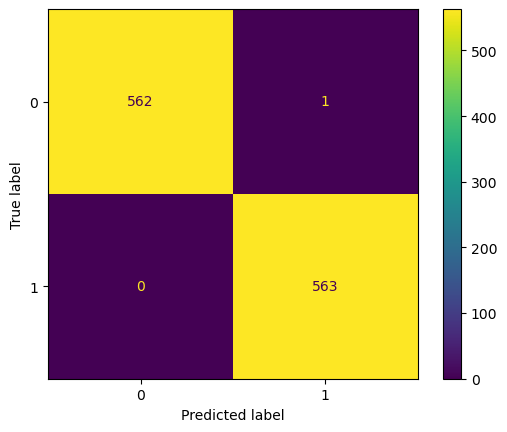

<Figure size 640x480 with 0 Axes>

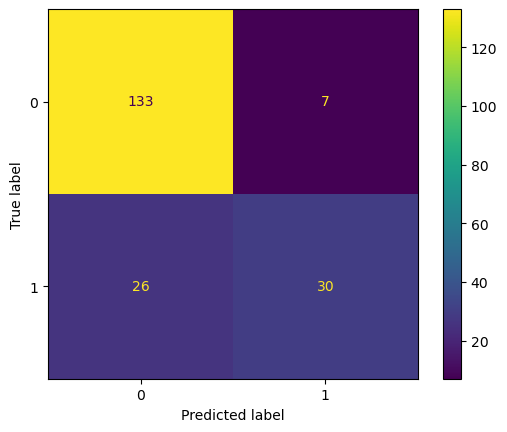

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# show training confusion matrix
cm_train = confusion_matrix(y_train, y_p_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.show()
plt.clf()

# show testing confusion matrix
cm_test = confusion_matrix(y_test, y_p_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.show()

### Try tuning random forest model

#### tune hyperparameters

In [17]:
# import libraries
from sklearn.model_selection import GridSearchCV

# define parameters
params = {
    "max_features": [i for i in range(1,11)],
    "min_samples_leaf": [i for i in range(1, 6)],
    "max_depth": [4, 6, 8, 10, 12]
}

# perform cross validation to get model
test_model = RandomForestClassifier()
clf = GridSearchCV(test_model, params)

# fit best model and get predictions
clf.fit(X_train, y_train)
y_p_train = clf.predict(X_train)
y_p_test = clf.predict(X_test)
train_acc = accuracy_score(y_train, y_p_train)
train_f1 = f1_score(y_train, y_p_train)
test_acc = accuracy_score(y_test, y_p_test)
test_f1 = f1_score(y_test, y_p_test)


print(f"TRAINING ACCURACY: {train_acc}")
print(f"TRAINING F1 SCORE: {train_f1}")
print(f"TESTING ACCURACY: {test_acc}")
print(f"TESTING F1 SCORE: {test_f1}")

TRAINING ACCURACY: 0.9928952042628775
TRAINING F1 SCORE: 0.9928825622775801
TESTING ACCURACY: 0.8418367346938775
TESTING F1 SCORE: 0.6804123711340206


In [18]:
clf.best_params_

{'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 1}

### Try result

TRAINING ACCURACY: 0.9955595026642984
TRAINING F1 SCORE: 0.9955634427684117
TESTING ACCURACY: 0.8316326530612245
TESTING F1 SCORE: 0.6526315789473685


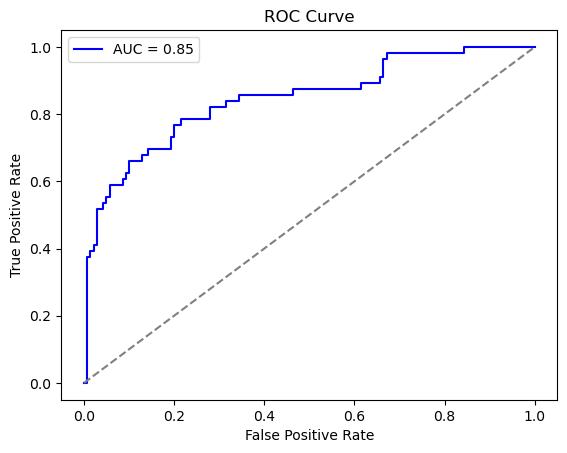

<Figure size 640x480 with 0 Axes>

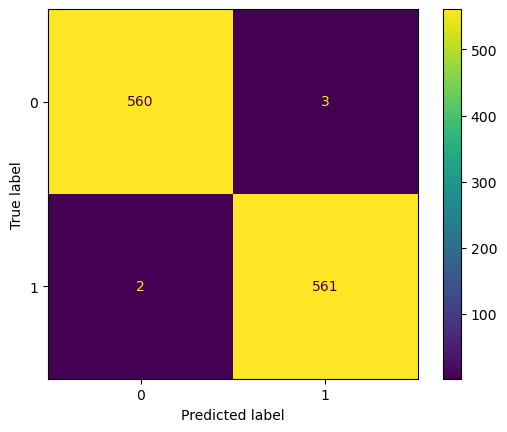

<Figure size 640x480 with 0 Axes>

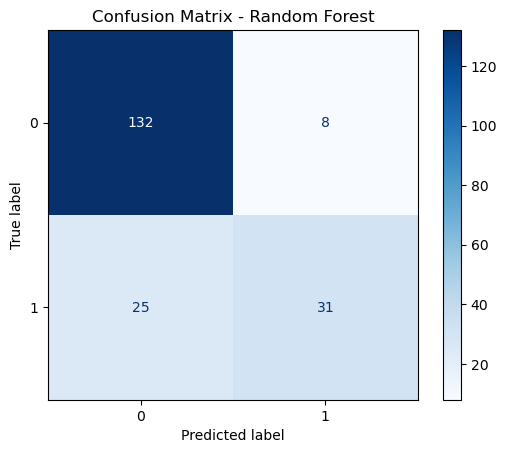

In [13]:
from sklearn.metrics import roc_curve, auc

# train model
model = RandomForestClassifier(
    max_depth=12,
    max_features=3,
    min_samples_leaf=1,
    random_state=25
)
model.fit(X_train, y_train)

# get training and test predictions
y_p_train = model.predict(X_train)
y_probs_test = model.predict_proba(X_test)[:, 1]
y_p_test = model.predict(X_test)

# show accuracy scores
train_acc = accuracy_score(y_train, y_p_train)
train_f1 = f1_score(y_train, y_p_train)
test_acc = accuracy_score(y_test, y_p_test)
test_f1 = f1_score(y_test, y_p_test)
print(f"TRAINING ACCURACY: {train_acc}")
print(f"TRAINING F1 SCORE: {train_f1}")
print(f"TESTING ACCURACY: {test_acc}")
print(f"TESTING F1 SCORE: {test_f1}")

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
plt.clf()

# show training confusion matrix
cm_train = confusion_matrix(y_train, y_p_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.show()
plt.clf()

# show testing confusion matrix
cm_test = confusion_matrix(y_test, y_p_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")

plt.show()

<Axes: ylabel='feature'>

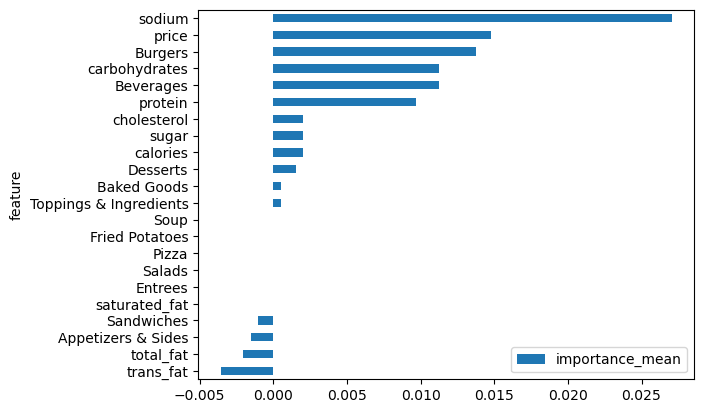

In [20]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# calculate permutation feature importance
result = permutation_importance(model, X_test, y_test, n_repeats=10)
feature_names = X_test.columns
result_df = pd.DataFrame({"feature": feature_names, "importance_mean": result.importances_mean})
result_df = result_df.sort_values(by="importance_mean", ascending=True)

# plot feature importances
result_df.plot.barh(x="feature", y="importance_mean")